# Complex Networks Computational Session
# Spectral properties, Laplacian

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from scipy import linalg as sla
import scipy.sparse as sparse
import pandas as pd

In [2]:
# Function to visualize an adjacency matrix
def plot_adjacency_matrix(adj_matrix, title="Adjacency Matrix"):
    plt.figure(figsize=(6,6))
    plt.imshow(adj_matrix, cmap='gray_r', interpolation='none')
    plt.title(title)
    plt.colorbar(label="Edge Weight")
    plt.show()

# Check if A is symmetric (difference between A and A.T is zero) without using numpy's isclose function
def is_symmetric(A):
    return np.all(A - A.T == 0)

def erdos_renyi(N,p,symmetric=True):
    A = np.random.rand(N,N)
    A = A<p
    if symmetric:
        A = np.triu(A,1)
        A = A + A.T
    return A

def generate_sbm(sizes, p_in, p_out,symmetric=True):
    n = sum(sizes)
    adj = np.zeros((n, n))
    # Intra-community links
    start = 0
    for i, size in enumerate(sizes):
        end = start + size
        adj[start:end, start:end] = np.random.rand(size, size) < p_in[i]
        if symmetric:
            #symmetrize
            adj[start:end, start:end] = np.triu(adj[start:end, start:end],1)
            adj[start:end, start:end] = adj[start:end, start:end] + adj[start:end, start:end].T
        start = end
    # Inter-community links
    for i in range(len(sizes)):
        for j in range(i+1, len(sizes)):
            start_i, end_i = sum(sizes[:i]), sum(sizes[:i+1])
            start_j, end_j = sum(sizes[:j]), sum(sizes[:j+1])
            adj[start_i:end_i, start_j:end_j] = np.random.rand(end_i-start_i, end_j-start_j) < p_out[i,j]
            if symmetric:
                adj[start_j:end_j, start_i:end_i] = adj[start_i:end_i, start_j:end_j].T
            else:
                adj[start_j:end_j, start_i:end_i] = np.random.rand(end_j-start_j, end_i-start_i) < p_out[i,j]
    return adj

In [3]:
edgelist=pd.read_csv('https://snap.stanford.edu/data/email-Eu-core.txt.gz', compression='gzip',sep=' ',header=None)
print(edgelist.head())


   0  1
0  0  1
1  2  3
2  2  4
3  5  6
4  5  7


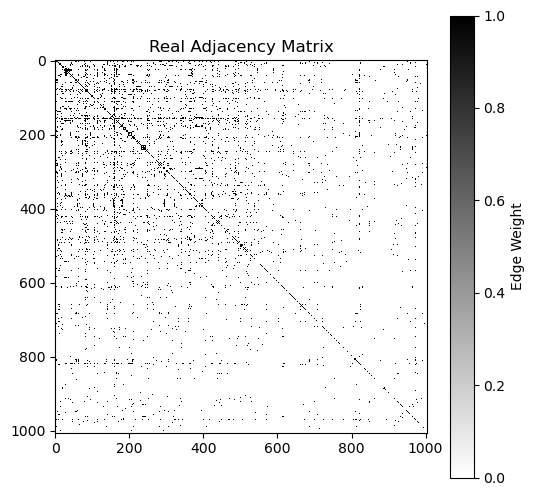

Graph with 1005 nodes and 16706 edges
Density: 0.03311331787278746


In [4]:
G_real = nx.Graph()
G_real.add_edges_from(edgelist.values)
A_real = nx.adjacency_matrix(G_real).todense()
plot_adjacency_matrix(A_real, "Real Adjacency Matrix")
print(G_real)
print('Density:',nx.density(G_real))

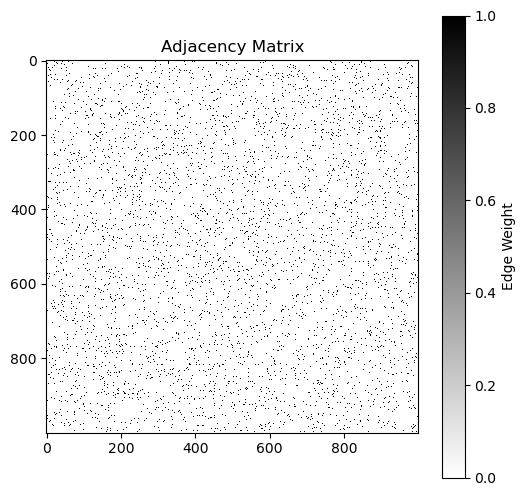

Graph with 1000 nodes and 16495 edges
Density: 0.03302302302302302


In [5]:
A_ER=erdos_renyi(1000,0.033,symmetric=True)
plot_adjacency_matrix(A_ER)
G_ER=nx.Graph(A_ER)
print(G_ER)
print('Density:',nx.density(G_ER))

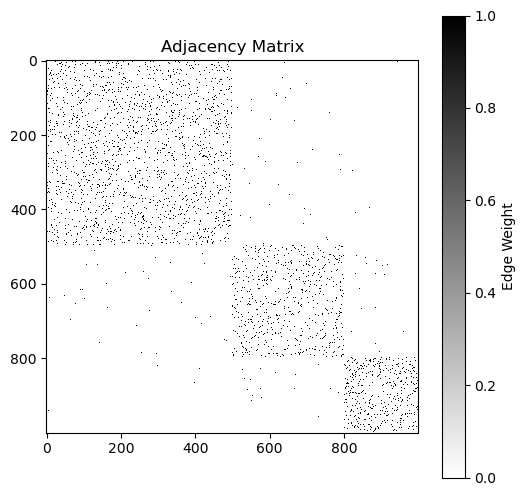

Graph with 1000 nodes and 10195 edges
Density: 0.02041041041041041


In [6]:
A_SBM=generate_sbm([500,300,200],[0.05,0.05,0.07],
                   np.array([[np.nan,0.0015,0.0005],
                             [np.nan,np.nan,0.002],
                             [np.nan,np.nan,np.nan]]))
plot_adjacency_matrix(A_SBM)
G_SBM=nx.Graph(A_SBM)
print(G_SBM)
print('Density:',nx.density(G_SBM))

## Spectral properties

**NOTE:** _eigh_ is faster than _eig_ if one is sure that the matrix is symmetric. _eigvalsh_ is even more efficient if one needs to compute only eigenvalues withour eigenvectors.

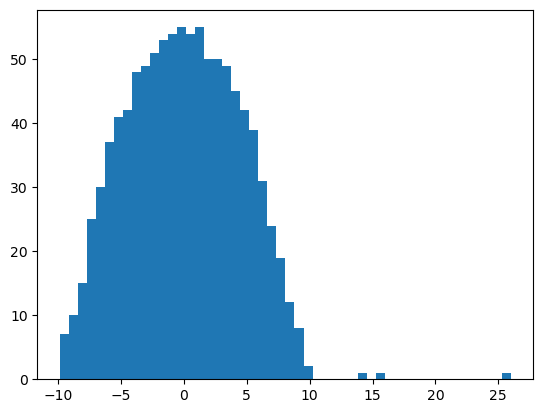

In [14]:
plt.hist(sla.eigvalsh(A_SBM), bins=50);

In [ ]:
print(np.max(np.abs(sla.eigvalsh(A_real))))

In [16]:
np.sum(A_SBM)/2

10195.0

In [17]:
p=(np.sum(A_SBM)/2) / (1000*(1000-1)/2)
print(p)    
#wigner's R
2*np.sqrt(1000*p*(1-p))

0.02041041041041041


8.942891156061114

The larger the gap between first and second eigenvalue, the more resilient is the network to distruptions (stronger structure).

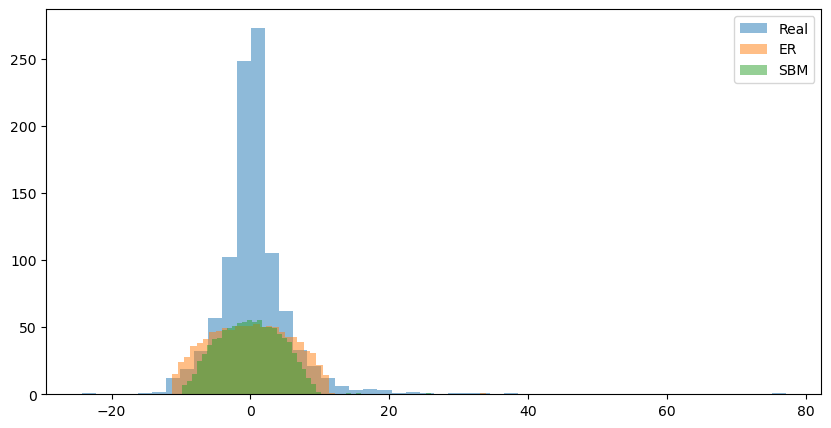

In [11]:
# Wigner's law R=2*rad(Np(1-p))
f=plt.figure(figsize=(10,5))
plt.hist(sla.eigvalsh(A_real),bins=50,alpha=0.5,label='Real')
plt.hist(sla.eigvalsh(A_ER),bins=50,alpha=0.5,label='ER')
plt.hist(sla.eigvalsh(A_SBM),bins=50,alpha=0.5,label='SBM')
plt.legend()

In [23]:
len([el for el in nx.connected_components(G_real)])

20

In [25]:
[len(nodes) for nodes in nx.connected_components(G_real)]

[986, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [24]:
# Number of connected components: count the number of 0 eigenvalues + 1
1+np.sum(np.abs(sla.eigvalsh(A_real))<1e-10)

20

<BarContainer object of 1005 artists>

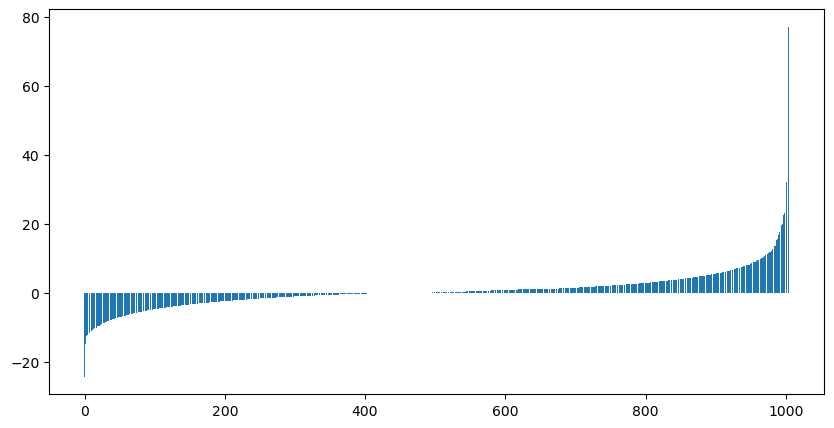

In [80]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(len(A_real)),sla.eigvalsh(A_real))